In [63]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Preprocessing

### Load Dataset

In [51]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
        
        # Extract features and labels
        X = data[b'data']
        y = data[b'labels']
        
        # Reshape features to (number of samples, 32, 32, 3)
        X = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        return X, np.array(y)

In [41]:
X_data = []
y_data = []

In [47]:
for batch in range(1, 6):
    X_batch, y_batch = unpickle(f'./cifar-10-batches-py/data_batch_{batch}')
    X_data.append(X_batch)
    y_data.append(y_batch)

# Combine all batches into one dataset
X_data_full = np.concatenate(X_data)
y_data_full = np.concatenate(y_data)

### Splitting
Split the model into training (80%), testing (10%), and validation (10%)

In [48]:
# split into training and a temporary set called tv -> training is 80%
X_train, X_tv, y_train, y_tv = train_test_split(X_data_full, y_data_full, test_size=0.8, random_state=42)

# split the temporary set into test and validation
X_test, X_val, y_test, y_val = train_test_split(X_tv, y_tv, test_size=0.5, random_state=42)

### Normalize pixel values

In [58]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

### Visualizing Data

In [59]:
def visualize_cifar10_images(images, labels, class_names, num_images=10):
    """
    Visualizes a grid of CIFAR-10 images.

    Parameters:
    - images: The input array of images (e.g., (num_samples, 32, 32, 3))
    - labels: The array of corresponding labels
    - class_names: List of class names that correspond to the numerical labels
    - num_images: Number of images to display in the grid (must be a perfect square)
    """
    # Ensure the number of images is a perfect square for a square grid layout
    grid_size = int(np.sqrt(num_images))
    assert grid_size * grid_size == num_images, "Number of images should be a perfect square."

    # Create a plot with grid_size x grid_size subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    fig.suptitle("CIFAR-10 Images", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            # Show the image on the subplot
            ax.imshow(images[i])
            # Set the title with the class name
            ax.set_title(class_names[labels[i]])
            ax.axis("off")  # Hide axes

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [60]:
def load_cifar10_meta(meta_file):
    with open(meta_file, 'rb') as file:
        meta = pickle.load(file, encoding='bytes')
        class_names = [label.decode('utf-8') for label in meta[b'label_names']]
        return class_names


# Load the class names
class_names = load_cifar10_meta('./cifar-10-batches-py/batches.meta')

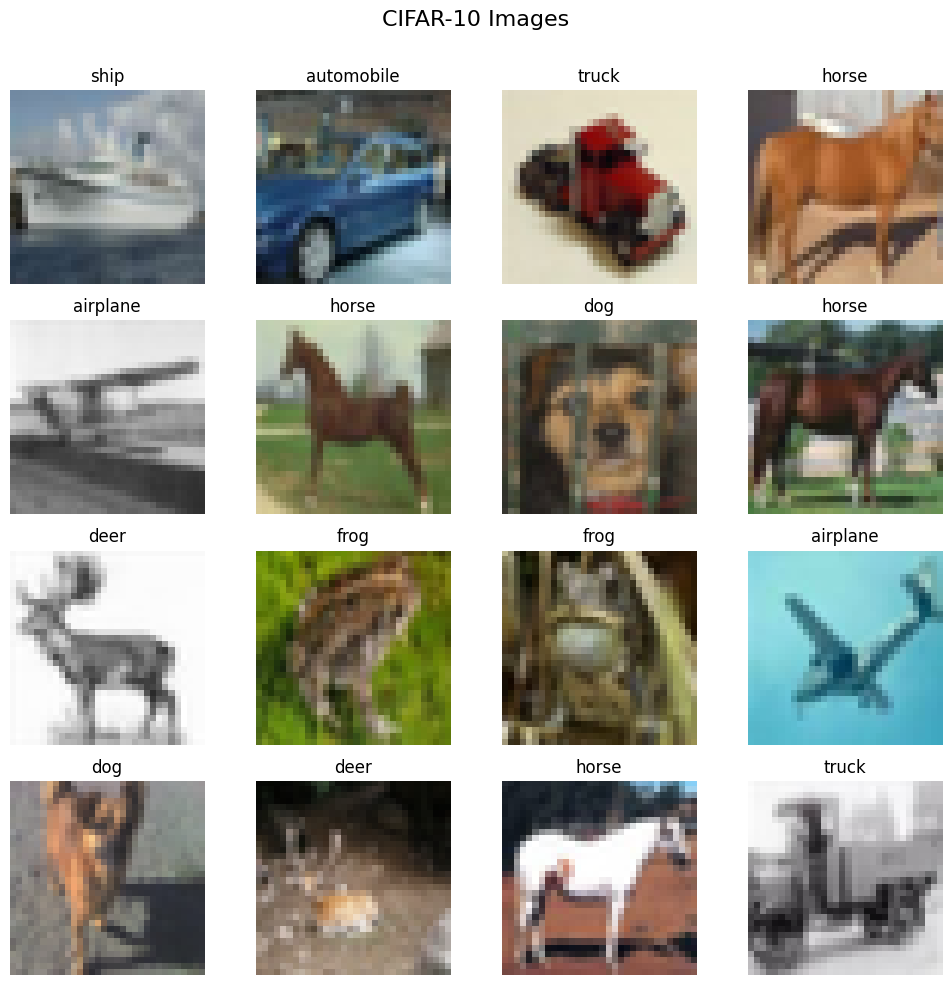

In [61]:
num_images_to_show = 16

visualize_cifar10_images(X_train[:num_images_to_show],y_train[:num_images_to_show], class_names, num_images=num_images_to_show)

### Augment

In [64]:
datagen = ImageDataGenerator(
    rotation_range=15,      # Random rotations up to 15 degrees
    width_shift_range=0.1,  # Random horizontal shifts up to 10% of the width
    height_shift_range=0.1,  # Random vertical shifts up to 10% of the height
    horizontal_flip=True    # Randomly flip the image horizontally
)

datagen.fit(X_train)

# Use the datagen.flow() method to create an augmented data generator
batch_size = 32
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)


## Model Architecture